In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import reset_seed, display_compare

import os

# tf.config.experimental.get_visible_devices()

# Images reconstruction

In [2]:
from sklearn.model_selection import train_test_split
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_full = np.float32(x_train_full/255.)
x_test       = np.float32(x_test/255.)
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, random_state=0)
print(x_train.shape)

(45000, 28, 28)


# Convolutional Autoencoders
### 3D Codings

In [6]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.nn import leaky_relu
from tensorflow.keras.optimizers import SGD

def get_conv_autoencoder(n_filters=8):
    encoder = Sequential([
        Reshape([28, 28, 1], input_shape=[28, 28]),
        Conv2D(n_filters, 3, strides=2, padding="same", activation=leaky_relu),
        Conv2D(2*n_filters, 3, strides=2, padding="same", activation=leaky_relu),
        Conv2D(4*n_filters, 3, strides=2, padding="valid", activation=leaky_relu),
    ])
    
    decoder = Sequential([
        Input(shape=[3, 3, 4*n_filters]),
        Conv2DTranspose(2*n_filters, 3, strides=2, padding="valid", activation=leaky_relu),
        Conv2DTranspose(1*n_filters, 3, strides=2, padding="same", activation=leaky_relu),
        Conv2DTranspose(1, 3, strides=2, padding="same", activation="sigmoid"),
        Reshape([28, 28])
    ])
    return Sequential([encoder, decoder])

In [7]:
reset_seed()
conv_ae = get_conv_autoencoder()
conv_ae.compile(loss="binary_crossentropy", optimizer=SGD(.1))
conv_ae.layers[0].summary()
conv_ae.layers[1].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 32)          4640      
Total params: 5,888
Trainable params: 5,888
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 16)          4624      
______________________________

In [8]:
conv_ae.fit(x_train, x_train, epochs=5, verbose=0, validation_data=(x_val, x_val))

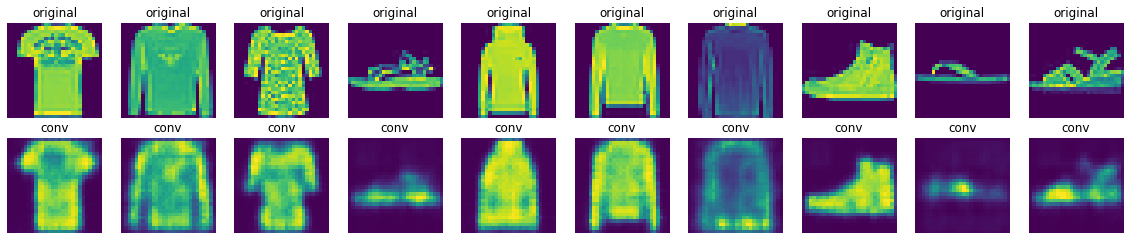

In [9]:
conv_rec = conv_ae.predict(x_val)

display_compare(x_val,  conv_rec, names=["original", "conv"])

In [10]:
reconstructions = []
filters = [2, 4, 8, 16]
for n_filters in filters:
    reset_seed()
    dc_ae = get_conv_autoencoder(n_filters=n_filters)
    dc_ae.compile(loss="binary_crossentropy", optimizer=SGD(.1))
    dc_ae.fit(x_train, x_train, epochs=10, verbose=0)
    reconstructions.append(dc_ae.predict(x_val))

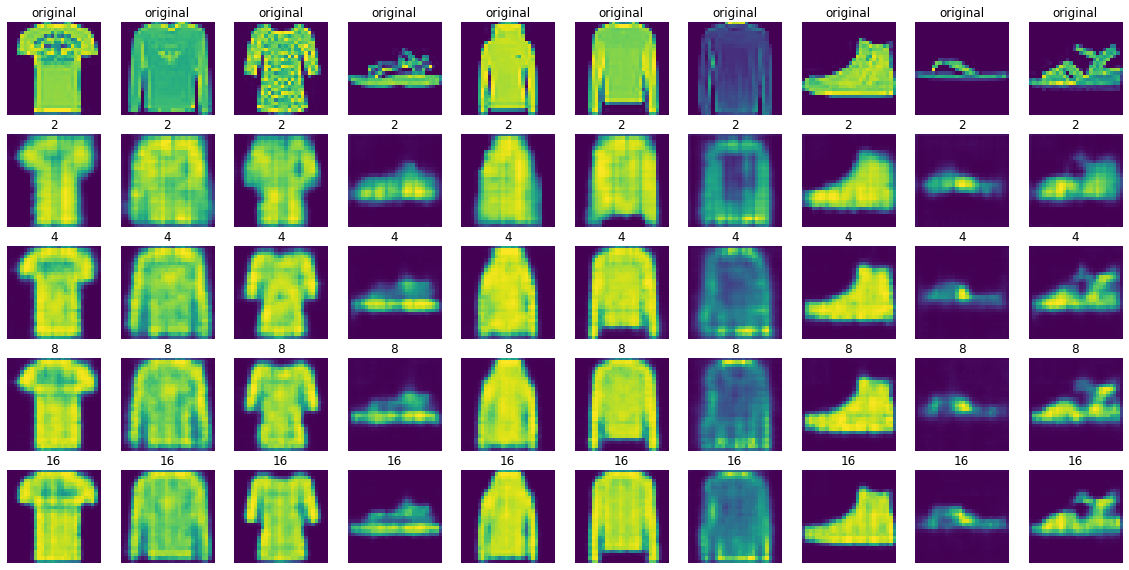

In [11]:
display_compare(x_val, *reconstructions, names=['original']+filters)

### Flat Codings

In [21]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Input

def get_flat_conv_autoencoder(latent_dim=10, n_filters=8):
    encoder = Sequential([
        Reshape([28, 28, 1], input_shape=[28, 28]),
        Conv2D(n_filters, 3, strides=2, padding="same", activation=leaky_relu),
        Conv2D(2*n_filters, 3, strides=2, padding="same", activation=leaky_relu),
        Conv2D(4*n_filters, 3, strides=2, padding="valid", activation=leaky_relu),
        Flatten(),
        Dense(latent_dim)
    ])
    
    decoder = Sequential([
        Input(shape=[latent_dim]),
        Dense(3*3*4*n_filters),
        Reshape([3, 3, 4*n_filters]),
        Conv2DTranspose(2*n_filters, 3, strides=2, padding="valid", activation=leaky_relu),
        Conv2DTranspose(1*n_filters, 3, strides=2, padding="same", activation=leaky_relu),
        Conv2DTranspose(1, 3, strides=2, padding="same", activation="sigmoid"),
        Reshape([28, 28])
    ])
    return Sequential([encoder, decoder])

In [22]:
reset_seed()
dcf_ae = get_flat_conv_autoencoder()
dcf_ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(.1))
dcf_ae.layers[0].summary()
dcf_ae.layers[1].summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten_6 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2890      
Total params: 8,778
Trainable params: 8,778
Non-trainable params: 0
___________________________________________________

In [23]:
dcf_ae.fit(x_train, x_train, epochs=5, verbose=1, validation_data=(x_val, x_val))

Epoch 1/5
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5987 - val_loss: 0.5980
Epoch 2/5
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5877 - val_loss: 0.5746
Epoch 3/5
1407/1407 [==============================] - 5s 3ms/step - loss: 0.4393 - val_loss: 0.3523
Epoch 4/5
1407/1407 [==============================] - 5s 3ms/step - loss: 0.3375 - val_loss: 0.3289
Epoch 5/5
1407/1407 [==============================] - 5s 3ms/step - loss: 0.3214 - val_loss: 0.3171


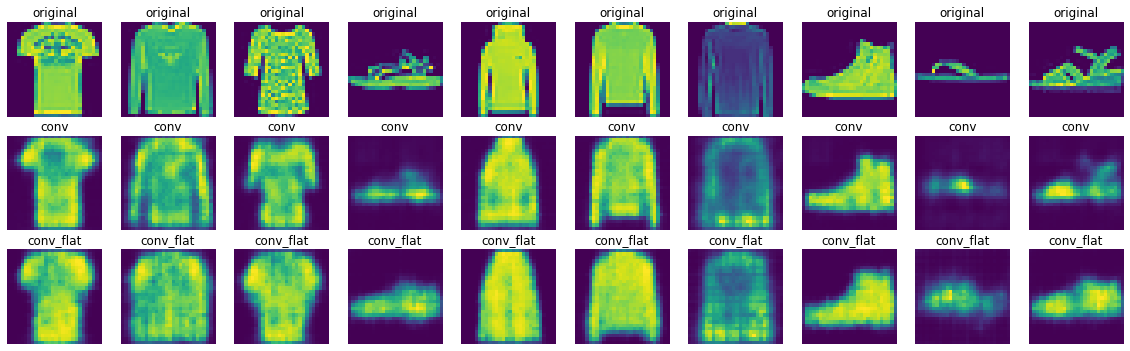

In [24]:
dcf_rec = dcf_ae.predict(x_val)

display_compare(x_val, conv_rec, dcf_rec, names=["original", "conv", "conv_flat"])

In [25]:
reconstructions = []
filters = [2, 4, 8, 16]
for n_filters in filters:
    reset_seed()
    dc_ae = get_flat_conv_autoencoder(n_filters=n_filters)
    dc_ae.compile(loss="binary_crossentropy", optimizer=SGD(.1))
    dc_ae.fit(x_train, x_train, epochs=10, verbose=0)
    reconstructions.append(dc_ae.predict(x_val))

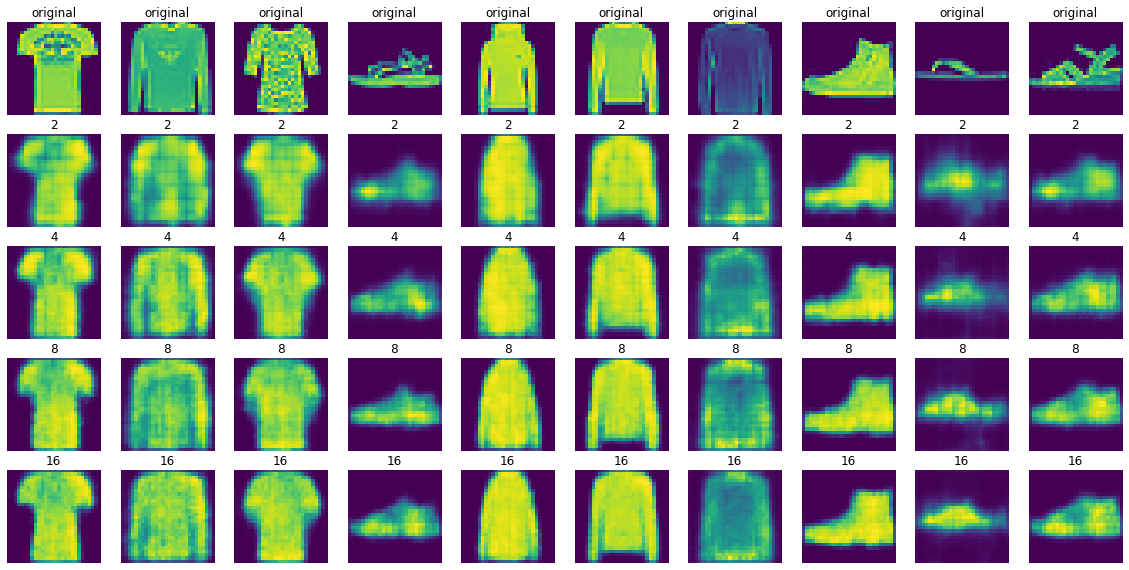

In [26]:
display_compare(x_val, *reconstructions, names=['original']+[str(f) for f in filters])

## Codings representation
Using the flat codings we can set the latent dimension to 2

In [27]:
tf.random.set_seed(0)
np.random.seed(0)

low_dcf_ae = get_flat_conv_autoencoder(latent_dim=2)
low_dcf_ae.compile(loss="binary_crossentropy", optimizer=SGD(1.))
low_dcf_ae.fit(x_train, x_train, epochs=20, verbose=0)

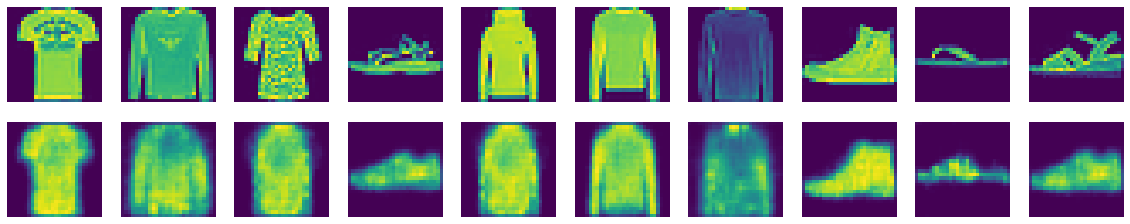

In [28]:
rec_low_ae = low_dcf_ae.predict(x_val)
display_compare(x_val, rec_low_ae)

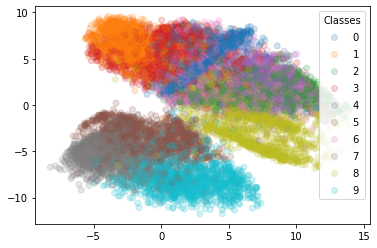

In [29]:
encoder = low_dcf_ae.layers[0]
codings = encoder.predict(x_val)
scatter = plt.scatter(*np.hsplit(codings,2), c=y_val, cmap="tab10", alpha=0.2)
legend1 = plt.legend(*scatter.legend_elements(), loc="best", title="Classes")